In [1]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, RepeatVector, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def read_data():
    path = "drive/MyDrive/Model_NMT_download/"
    input_train = []
    output_train = []
    with open(path + 'train.en.txt') as f:
        for line in f.readlines():
            input_train.append(line)
    with open(path + 'train.de.txt') as f:
        for line in f.readlines():
            output_train.append(line)
    print(len(input_train))
    print(len(output_train))
    return input_train, output_train
def clean_text(text):
    text = text.lower()
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    return text
def eda(input_train,output_train):
    #To perform exploratory data analysis (EDA) on the training data.
    df = pd.DataFrame(data = {'input':input_train[:10000],'output':output_train[:10000]})
    print("The number of na values is\n",df.isna().sum())
    print("The number of duplicated values is\n",df.duplicated().sum())
    df_processed = df.drop_duplicates()

    df_processed['eng_len'] = df_processed.input.apply(len)
    df_processed['ger_len'] = df_processed.output.apply(len)
    print(df_processed.head(2))
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    sns.distplot(df_processed.eng_len,ax=axes[0])
    sns.distplot(df_processed.ger_len,ax=axes[1])
    print("The preprocessed dataframe statistics are as follows:\n")
    print(df_processed.describe())
    return df_processed
def show_wordcloud(df_column):
    wc = WordCloud(width=600,height=300).generate(' '.join(df_column))
    plt.imshow(wc);
def preprocess_data(df_processed):
    df_processed.input = df_processed.input.progress_apply(clean_text)
    #progress_apply it is used to view the progress that is made while cleaning the data
    df_processed.output = df_processed.output.progress_apply(clean_text)
    df_processed.output = df_processed.output.apply(lambda x: '<START> ' + x + ' <END>')
    #The text is converted into a uniform format of padded sequences of integers, where each integer represents a specific word.
    eng_tokenizer = Tokenizer()
    eng_tokenizer.fit_on_texts(df_processed.input)
    eng_vocab_size = len(eng_tokenizer.word_index) + 1
    print(eng_vocab_size)
    eng_sequences = eng_tokenizer.texts_to_sequences(df_processed.input)
    eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')
    #The text is converted into a uniform format of padded sequences of integers, where each integer represents a specific word.
    ger_tokenizer = Tokenizer()
    #fit_on_texts is about training the tokenizer on the German text, allowing it to develop a mapping from words to integers.
    ger_tokenizer.fit_on_texts(df_processed.output)
    ger_vocab_size = len(ger_tokenizer.word_index) + 1
    print(ger_vocab_size)
    # The texts_to_sequences will convert the text to sequence of integers
    ger_sequences = ger_tokenizer.texts_to_sequences(df_processed.output)
    ger_pad_sequences = pad_sequences(ger_sequences,maxlen=max_ger_len,dtype='int32',padding='post',truncating='post')
    return eng_vocab_size, ger_vocab_size, eng_pad_sequences, ger_pad_sequences, eng_tokenizer, ger_tokenizer

#Define Hyperparameters

In [4]:
#define hyperparameters
max_eng_len = 649
max_ger_len = 649
latent_dim = 30
embedding_dim = 10

In [5]:
#read data and get input and output
input, output = read_data()

4468840
4468840


The number of na values is
 input     0
output    0
dtype: int64
The number of duplicated values is
 1
                                               input  \
0  iron cement is a ready for use paste which is ...   
1  iron cement protects the ingot against the hot...   

                                              output  eng_len  ger_len  
0  iron cement ist eine gebrauchs ##AT##-##AT## f...      146      185  
1  Nach der Aushärtung schützt iron cement die Ko...       82       94  
The preprocessed dataframe statistics are as follows:

           eng_len      ger_len
count  9999.000000  9999.000000
mean    140.540754   145.752675
std      79.559802    81.221845
min      23.000000    24.000000
25%      83.000000    87.000000
50%     121.000000   127.000000
75%     179.000000   184.000000
max     649.000000   701.000000


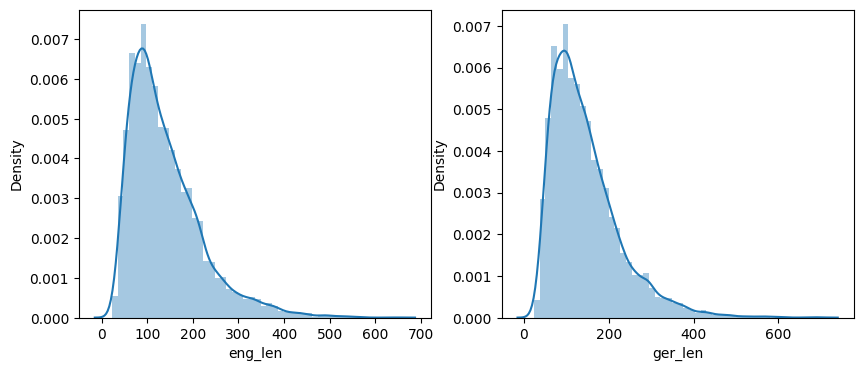

In [6]:
df_processed = eda(input, output)

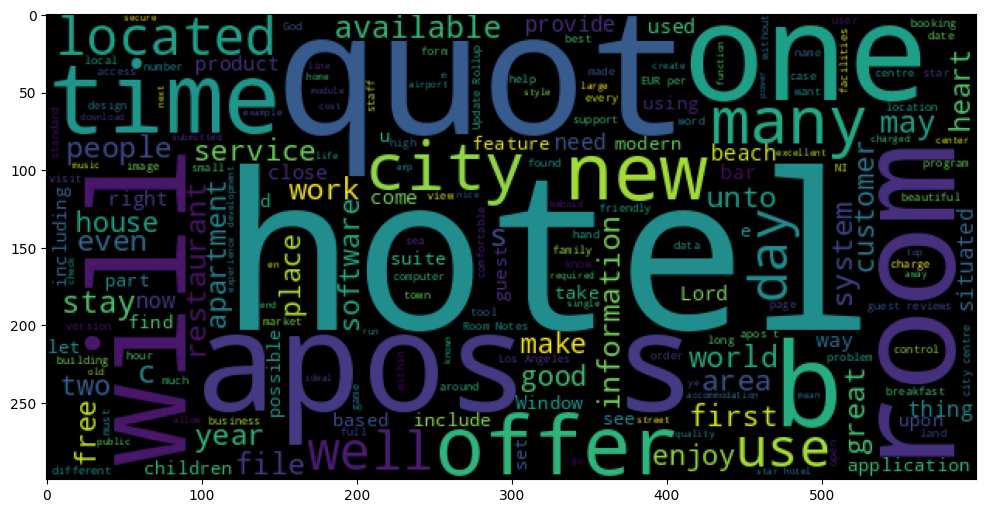

In [7]:
show_wordcloud(df_processed.input)

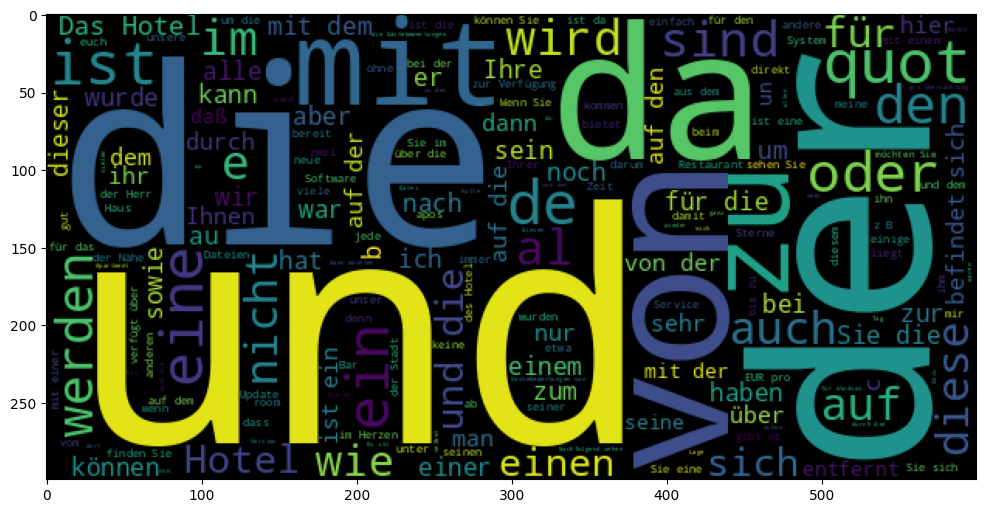

In [8]:
show_wordcloud(df_processed.output)

In [9]:
eng_vocab_size, ger_vocab_size, eng_pad_sequences, ger_pad_sequences, eng_tokenizer, ger_tokenizer = preprocess_data(df_processed)

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

19429
29844


#Create Model

In [10]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.Modified_W_a = self.add_weight(name='Modified_W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.Modified_U_a = self.add_weight(name='Modified_U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.Modified_V_a = self.add_weight(name='Modified_V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        Modified_encoder_out_seq, Modified_decoder_out_seq = inputs

        logger.debug(f"Modified_encoder_out_seq.shape = {Modified_encoder_out_seq.shape}")
        logger.debug(f"Modified_decoder_out_seq.shape = {Modified_decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            Modified_encoder_full_seq = states[-1]

            """ Computing S.Modified_Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            Modified_W_a_dot_s = K.dot(Modified_encoder_full_seq, self.Modified_W_a)

            """ Computing hj.Modified_Ua """
            Modified_U_a_dot_h = K.expand_dims(K.dot(inputs, self.Modified_U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"Modified_U_a_dot_h.shape = {Modified_U_a_dot_h.shape}")

            """ tanh(S.Modified_Wa + hj.Modified_Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Modified_Ws_plus_Uh = K.tanh(Modified_W_a_dot_s + Modified_U_a_dot_h)

            logger.debug(f"Modified_Ws_plus_Uh.shape = {Modified_Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Modified_Wa + hj.Modified_Ua)) """
            # <= batch_size, en_seq_len
            #Modified_e_i is  used for generating the raw attention scores
            Modified_e_i = K.squeeze(K.dot(Modified_Ws_plus_Uh, self.Modified_V_a), axis=-1)
            # <= batch_size, en_seq_len
            Modified_e_i = K.softmax(Modified_e_i)

            logger.debug(f"Modified_ei.shape = {Modified_e_i.shape}")

            return Modified_e_i, [Modified_e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")
            #This is the dot product of the Modified_encoder_full_seq and decoder output whcih means to generate the context vector

            Modified_encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            Modified_c_i = K.sum(Modified_encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"Modified_ci.shape = {Modified_c_i.shape}")

            return Modified_c_i, [Modified_c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        Modified_fake_state_c = K.sum(Modified_encoder_out_seq, axis=1)
        Modified_fake_state_e = K.sum(Modified_encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # Modified_e_outputs => (batch_size, de_seq_len, en_seq_len)
        Modified_last_out, Modified_e_outputs, _ = K.rnn(
            energy_step, Modified_decoder_out_seq, [Modified_fake_state_e], constants=[Modified_encoder_out_seq]
        )

        """ Computing context vectors """
        Modified_last_out, Modified_c_outputs, _ = K.rnn(
            context_step, Modified_e_outputs, [Modified_fake_state_c], constants=[Modified_encoder_out_seq]
        )

        return Modified_c_outputs, Modified_e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [11]:
def Create_Model():
    K.clear_session()
    encoder_inputs = Input(shape=(max_eng_len,))
    encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

    encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, activation = "tanh", recurrent_activation = "sigmoid", recurrent_dropout=0)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

    encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, activation = "tanh", recurrent_activation = "sigmoid", recurrent_dropout=0)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, activation = "tanh", recurrent_activation = "sigmoid", recurrent_dropout=0)
    encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

    encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.25, activation = "tanh", recurrent_activation = "sigmoid", recurrent_dropout=0)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_output3)
    encoder_states = [state_h,state_c]

    decoder_inputs = Input(shape=(None,))
    decoder_emb = Embedding(ger_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, activation = "tanh", recurrent_activation = "sigmoid", recurrent_dropout=0)
    decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states)

    attn_layer = AttentionLayer(name='attention_layer')
    attn_outputs, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

    decoder_dense = TimeDistributed(Dense(ger_vocab_size,activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print(model.summary())
    return model, encoder_inputs, encoder_outputs, state_h, state_c, decoder_lstm, decoder_emb, attn_layer, decoder_dense, decoder_inputs

In [12]:
model, encoder_inputs, encoder_outputs, state_h, state_c, decoder_lstm, decoder_emb, attn_layer, decoder_dense, decoder_inputs = Create_Model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 649)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 649, 10)              194290    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 649, 30),            4920      ['embedding[0][0]']           
                              (None, 30),                                                         
                              (None, 30)]                                                         
                                                                                              

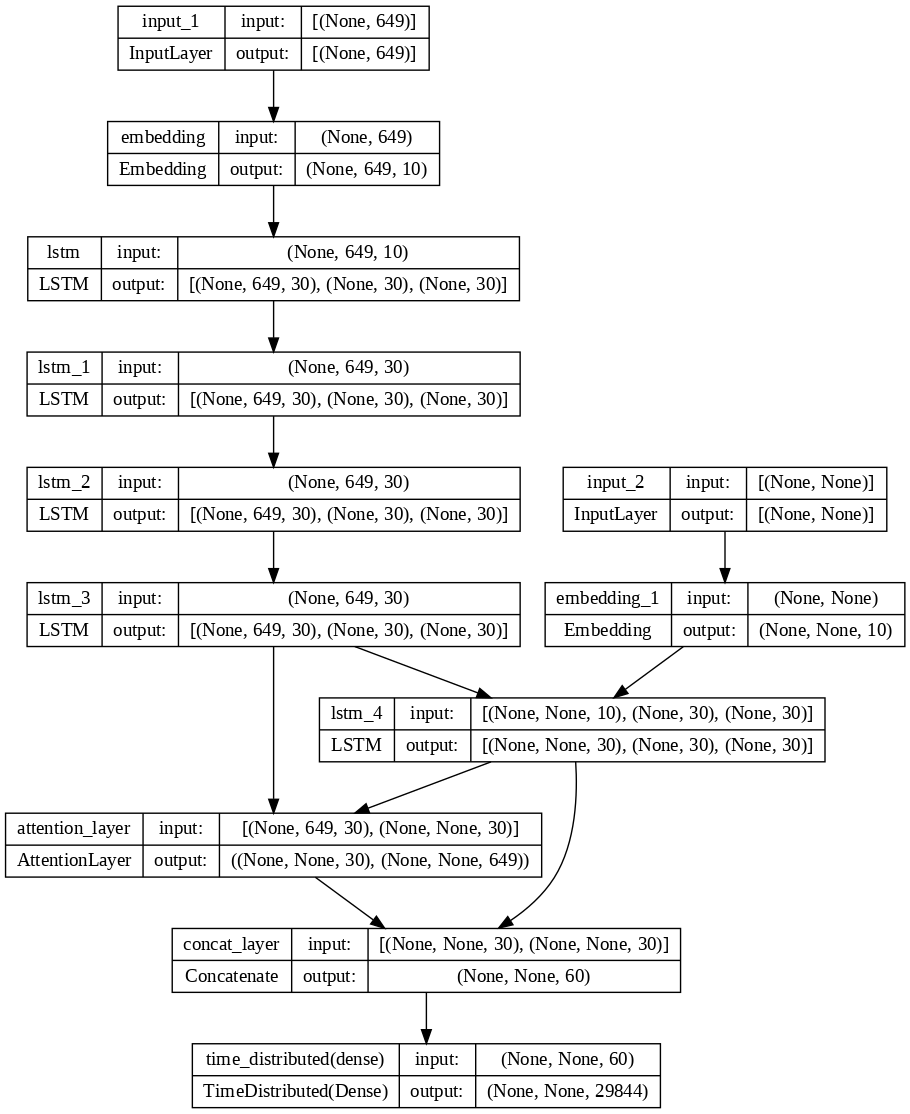

In [13]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [14]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
X_train, X_test, y_train, y_test = train_test_split(eng_pad_sequences,ger_pad_sequences,test_size=0.20,shuffle=True,random_state=88)
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.0001)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)
r = model.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=3,
             batch_size=16,
             callbacks=[es,rl,mc],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/3
500/500 [==============================] - ETA: 0s - loss: 1.6408 - accuracy: 0.9646
Epoch 1: val_accuracy improved from -inf to 0.96622, saving model to checkpoint/
500/500 [==============================] - 1149s 2s/step - loss: 1.6408 - accuracy: 0.9646 - val_loss: 0.2847 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 2/3
500/500 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.9681
Epoch 2: val_accuracy improved from 0.96622 to 0.96763, saving model to checkpoint/
500/500 [==============================] - 1097s 2s/step - loss: 0.2721 - accuracy: 0.9681 - val_loss: 0.2729 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 3/3
500/500 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9683
Epoch 3: val_accuracy improved from 0.96763 to 0.96764, saving model to checkpoint/
500/500 [==============================] - 1151s 2s/step - loss: 0.2655 - accuracy: 0.9683 - val_loss: 0.2692 - val_accuracy: 0.9676 - lr: 0.0010


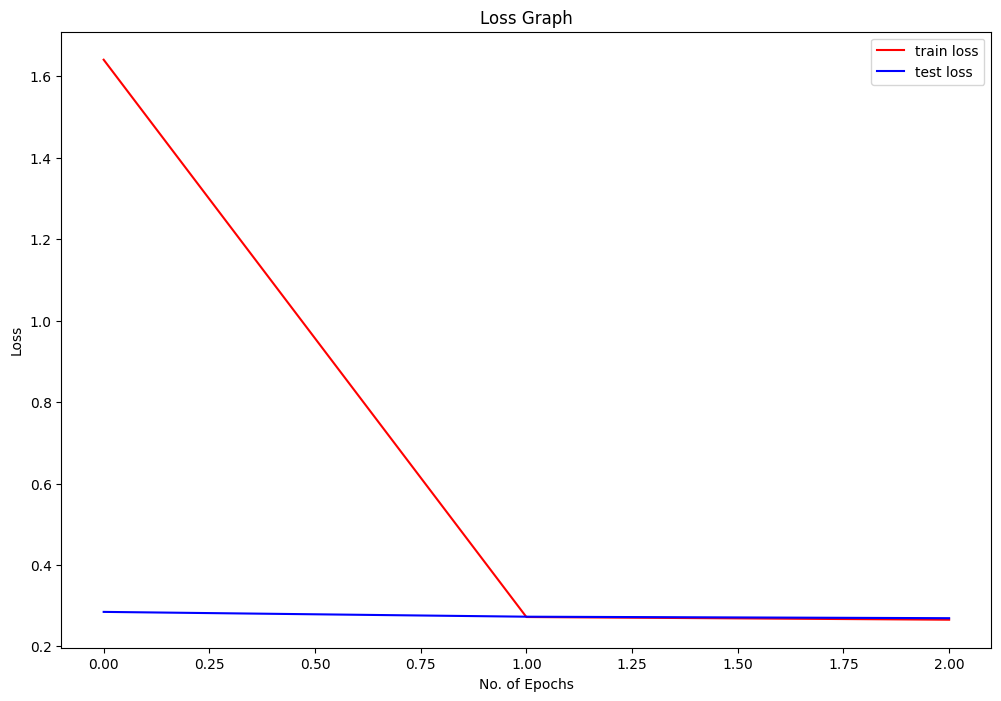

In [15]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

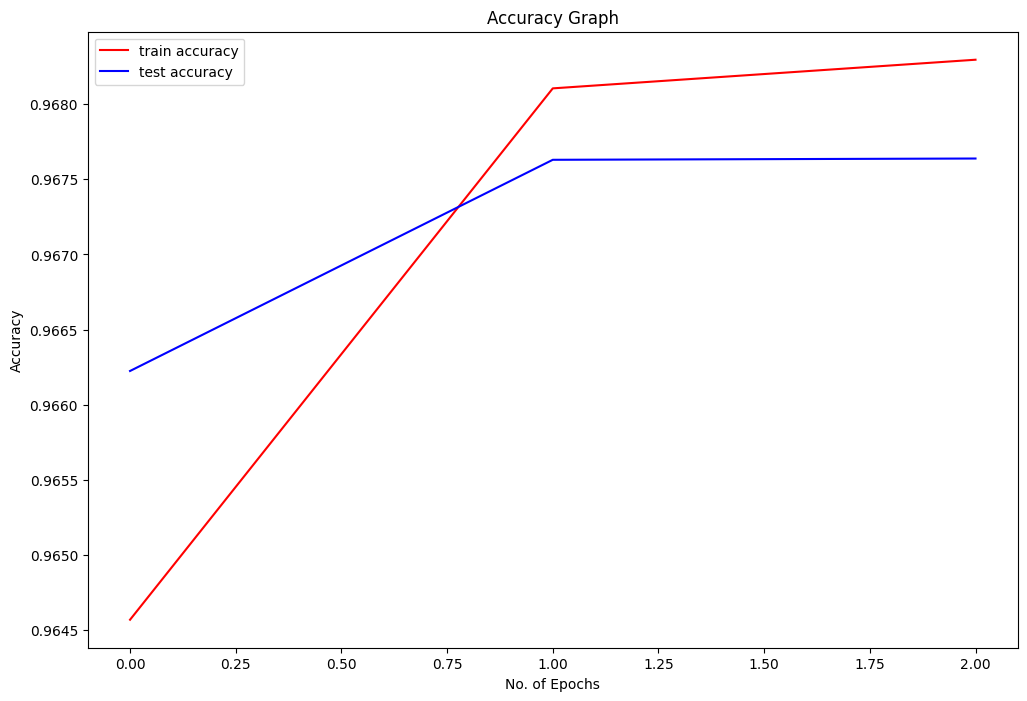

In [16]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [17]:
model.evaluate([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:])

63/63 [==============================] - 31s 455ms/step - loss: 0.2692 - accuracy: 0.9676


[0.2692466080188751, 0.9676389098167419]

In [18]:
model.save('english_to_german_translator.h5')
lm = load_model('english_to_german_translator.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [19]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_eng_len, latent_dim))

decoder_out, decoder_state_a, decoder_state_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat_outputs = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat_outputs)
decoder_model = Model([decoder_inputs]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_state_a, decoder_state_c])

In [20]:
def decode_sequences(input_sequence):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_sequence)
    next_input = np.zeros((1,1))
    next_input[0,0] = ger_tokenizer.word_index['start']
    output_sequence = ''
    flag = False
    while not flag:
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        output_idx = np.argmax(decoded_out[0, -1, :])
        if output_idx == ger_tokenizer.word_index['end']:
            flag = True
        elif output_idx > 0 and output_idx != ger_tokenizer.word_index['start']:
            output_token = ger_tokenizer.index_word[output_idx]
            output_sequence = output_sequence + ' ' + output_token
        next_input[0,0] = output_idx
        # Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c

    return output_sequence

In [21]:
def sequence_to_language(input_sequence,tokenizer,lang):
    res = ''

    if lang == 'eng':
        for idx in input_sequence:
            if idx != 0:
                res = res + tokenizer.index_word[idx] + ' '

    elif lang == 'ger':
        for idx in input_sequence:
            if idx > 0:
                if tokenizer.index_word[idx] != 'start' and tokenizer.index_word[idx] != 'end':
                    res = res + tokenizer.index_word[idx] + ' '

    return res

In [22]:
def predicted_sequence_to_ger_language(input_sequence):
    res = ''
    for idx in input_sequence:
        if idx > 0:
            if ger_tokenizer.index_word[idx] != 'start' and ger_tokenizer.index_word[idx] != 'end':
                res = res + ger_tokenizer.index_word[idx] + ' '

    return res

In [23]:
predicted_ger_translations= []

for i in range(20):
    print("English Sentence:",sequence_to_language(X_test[i],eng_tokenizer,'eng'))
    print("Original German Translation:",sequence_to_language(y_test[i],ger_tokenizer,'ger'))
    pred_german_sentence = decode_sequences(X_test[i].reshape(1,max_eng_len))
    print("Predicted German Translation:",pred_german_sentence)
    predicted_ger_translations.append(pred_german_sentence)

English Sentence: our chef will be glad to introduce you to remarkable sea recipes as well as recipes coming from the old elba isle traditions 
Original German Translation: elbanische traditionen und besonders gerichte von meeresspezialitäten sind die visitenkarte mit der sich unser chef den gästen präsentiert 
1/1 [==============================] - 0s 19ms/step
Predicted German Translation:  die die die die die und und und
English Sentence: the room of buddha where the warm glow of the sunset fits with the beautiful red and golden colours of this room 
Original German Translation: das buddha at at zimmer wo sich das warme licht des sonnenuntergangs mit den schönen roten und goldenen farbtönen des zimmers mischt 
1/1 [==============================] - 0s 23ms/step
Predicted German Translation:  die die die die die und und und
English Sentence: following american entry into the war the u s navy grew tremendously as the united states was faced with a two at at front war on the seas 
Orig

In [24]:
original_ger_translations = []
for i in range(20):
    original_ger_translations.append(sequence_to_language(y_test[i],ger_tokenizer,'ger'))
references = []

for trans in original_ger_translations:
    ref = trans.split()
    references.append(ref)

In [25]:
orig_ger_sents = []
smooth = SmoothingFunction().method4

for i in range(20):
    print("Original German Sentence:",references[i])
    print("Predicted German Sentence:",predicted_ger_translations[i])
    print("BLEU Score:",sentence_bleu(references[i],predicted_ger_translations[i],weights=(0.25,0.25,0.25,0.25)))

Original German Sentence: ['elbanische', 'traditionen', 'und', 'besonders', 'gerichte', 'von', 'meeresspezialitäten', 'sind', 'die', 'visitenkarte', 'mit', 'der', 'sich', 'unser', 'chef', 'den', 'gästen', 'präsentiert']
Predicted German Sentence:  die die die die die und und und
BLEU Score: 2.8480561297989097e-78
Original German Sentence: ['das', 'buddha', 'at', 'at', 'zimmer', 'wo', 'sich', 'das', 'warme', 'licht', 'des', 'sonnenuntergangs', 'mit', 'den', 'schönen', 'roten', 'und', 'goldenen', 'farbtönen', 'des', 'zimmers', 'mischt']
Predicted German Sentence:  die die die die die und und und
BLEU Score: 1.9153405461433417e-78
Original German Sentence: ['sie', 'bestimmen', 'bis', 'heute', 'das', 'denken', 'der', 'usn', 'in', 'erheblichem', 'maße']
Predicted German Sentence:  die die die die die und und und
BLEU Score: 4.470095426213435e-155
Original German Sentence: ['seit', '12', 'jänner', '2009', 'gibt', 'es', 'die', 'verpflichtende', 'einführung', 'des', 'elektronischen', 'systems'